# Why applying median correction is necessary

When calculating the Wasserstein distance with triku, the next step is to plot the distances against the mean expression of each gene. We usually see that genes of interest have a higher Wasserstein distance, as expected; but what is more important, their Wasserstein distance is much higher than the median distance for genes with similar expression. It is usually common to find that genes with much higher expression have biases towards higher distances. Those genes can be useful features, but generally there are better features, and those genes "obscure" them, since they basaly have a higher distance. 

Therefore, we should "correct" the Wasserstein distance considering the mean expression. The main idea is to obtain a baseline level, which can be easily done by calculating the median distance across the whole gene expression values (using log is less sensitive to expressing across differente scales, or orders of magnitude).

Afterwards we should remove that baseline level to each gene. We can do that in two ways:
* A simpler but coarser approach is to simply substract the median in each window to the distance of the gene in that window. This approach produces a more stepped graph, which can introduce artifacts if the number of windows is not high enough.
* We can adjust a cubic spline to the median in each window, and then apply the substraction to the interpolated values. This gives a smoother graph, and less prone to artifacts if the number of windows is not high enough. (Supposedly)

Regarding the number of windows, since we will always be considering around 5000 - 15000 genes, a number of windows around 50 - 200 will be enough. However, in some expression ranges (towards the high expression end), if the number of genes is not high enough (since most of them are concentrated towards lower expression values). 

To see differences in median correction, we will first work with artificial datasets with varying degrees of differentiale expression probabilities. Then we will extrapolate this method to biological datasets.

In [3]:
import scanpy as sc
import triku as tk
import numpy as np
from scipy import interpolate
import pandas as pd

seed = 1

/home/seth/anaconda3/envs/alex-base/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [4]:
%matplotlib inline

In [5]:
from bokeh.io import show, output_notebook, reset_output
from bokeh.plotting import figure
from bokeh.models import LinearColorMapper
from bokeh.transform import dodge

import matplotlib.pyplot as plt
import matplotlib as mpl

reset_output()
output_notebook()

Loading BokehJS ...

In [6]:
import sys, os
sys.path.insert(0, os.getcwd() + '/code')

# Selection of palettes for cluster coloring, and scatter values
from palettes_and_cmaps import magma, bold_and_vivid

In [7]:
dataset_dir = "../data/"

In [8]:
# The function is already defined within triku internals, but we will include it here to
# understand it better.
def subtract_median(x, y, n_windows, apply_spline):
    """x and y are mean and distance values."""
    
    # We have to take the distance in logarithm to account for the wide expression ranges
    linspace = 10**np.linspace(min(np.log10(x)), max(np.log10(x)), n_windows + 1)
    y_adjust = y.copy()
    
    if apply_spline:
        median_x, median_y = [], []
       
        for i in range(n_windows):
            mask = (x >= linspace[i]) & (x <= linspace[i + 1])
            if np.any(mask): # If the mask is empty there's no need to add anything because there are no genes
                median_y.append(np.median(y[mask]))
                median_x.append(np.median(x[mask]))      
        
        spline = interpolate.splrep(np.array(median_x), np.array(median_y), s=0)
        y_adjust -= interpolate.splev(x, spline)
        
        return y_adjust, spline
    else:
        y_median_array = np.zeros(len(y))
        for i in range(n_windows):
            mask = (x >= linspace[i]) & (x <= linspace[i + 1])
            y_median_array[mask] = np.median(y[mask])
        
        y_adjust -= y_median_array

        return y_adjust, None

## Is spline approximation better than step functions?
To answer that question we will take an artifitial dataset, and see how it behaves in a certain number of windows. We will use a low - mid range of windows (5 to 70), and a high range (100 - 1000).

In [9]:
def compare_windows_spline_step(list_windows, x, y):
    y_adj_spli_list, spline_list, y_adj_step_list = [], [], []
    
    for window in list_windows:
        y_adjs_w_spline, spline_w = subtract_median(x, y, n_windows=window, apply_spline=True)
        y_adjs_w_step, _ = subtract_median(x, y, n_windows=window, apply_spline=False)
        
        y_adj_spli_list.append(y_adjs_w_spline)
        spline_list.append(spline_w)
        y_adj_step_list.append(y_adjs_w_step)
        
    
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].scatter(np.log10(x), y, c = "#bcbcbc", s=4)
    axs[1].scatter(np.log10(x), y, c = "#bcbcbc", s=4)
    for ax in axs:
        ax.set_xlabel('log$_{10}$(mean expression)')
        ax.set_ylabel('Wasserstein distance')
    
    for w_idx in range(len(list_windows)):
        axs[0].plot(np.sort(np.log10(x)), interpolate.splev(np.sort(x), spline_list[w_idx]), 
                    alpha=0.65, label=list_windows[w_idx])
        axs[1].plot(np.sort(np.log10(x)), np.sort(y-y_adj_step_list[w_idx]), 
                    alpha=0.65, label=list_windows[w_idx])
        axs[0].legend(); axs[1].legend(); 

    plt.tight_layout()
    
    fig, axs2 = plt.subplots(len(list_windows), 2, figsize=(6, 3 * len(list_windows)))
    for w_idx in range(len(list_windows)):
        axs2[w_idx][0].scatter(np.log10(x), y - interpolate.splev(x, spline_list[w_idx]), s=1, 
                               label="Splin, W=%s"%list_windows[w_idx])
        axs2[w_idx][1].scatter(np.log10(x), y_adj_step_list[w_idx],  s=1, 
                              label="Step, W=%s"%list_windows[w_idx])
        axs2[w_idx][0].legend(); axs2[w_idx][1].legend()
        
    for ax in axs2.ravel():
        ax.set_xlabel('log$_{10}$(mean expression)')
        ax.set_ylabel('Wasserstein distance')
    
    plt.tight_layout()

In [ ]:
adata_splatter_005 = sc.read(dataset_dir + 'splatter/splatter_deprob_0.005.loom') #, cache=True)

In [ ]:
tk.tl.triku(adata_splatter_005)

In [ ]:
x = (np.asarray(adata_splatter_005.X.todense())).mean(0)
y = adata_splatter_005.var['emd_distance_uncorrected'].values -  adata_splatter_005.var['emd_distance_random'].values

In [ ]:
compare_windows_spline_step([15, 25, 50, 70], x, y)

In [ ]:
compare_windows_spline_step([100, 500, 1000, 5000], x, y)

In very low ranges (5 - 15/20), there are artifacts either in steps or in splines. In splines, the spline tends to go higher in the higher expression end, which is expected. As a result, distances on the higher end are lower than what they should be. Steps, on the other hand, produce an *stepping* artifact, that is, too many genes are selected in one window and, after substraction, it creates a zigzaggy pattern.

These two problems disappear with 50 - 70 windows, and the *corrected* distance pattern looks really similar with both methods. 

In the higher ends, opposited as expected, spline functions are erratic, and although they do not seem really apparent in the corrected scatter plots, there are some variations at 1000 and 5000 windows. However, we don't care about that number, so it is not that important.

We will now apply the same to two biological datasets: 10X, and a single cell skin dataset from Tabib et al. (Tabib 2018).

In [ ]:
adata_neuron10k = sc.read_10x_h5(dataset_dir + '10x/neuron_10k_v3_filtered_feature_bc_matrix.h5')
adata_neuron10k.var_names_make_unique()
sc.pp.filter_genes(adata_neuron10k, min_cells=10)

In [ ]:
tk.tl.triku(adata_neuron10k)

In [ ]:
x = (np.asarray(adata_neuron10k.X.todense())).mean(0)
y = adata_neuron10k.var['emd_distance_uncorrected'].values -  adata_neuron10k.var['emd_distance_random'].values

In [ ]:
compare_windows_spline_step([15, 25, 50, 70], x, y)

In [ ]:
compare_windows_spline_step([100, 500, 1000, 5000], x, y)

In this case we see that there is not much difference across windows or between methods. At 500 - 5000 windows, either splines and steps start producing artifacts at a log mean expresion of -2 to -1.

In [ ]:
tabib_2018 = sc.read_csv(dataset_dir + 'Tabib_2018/Skin_6Control_rawUMI.csv').transpose()
tabib_2018.var_names_make_unique()
sc.pp.filter_genes(tabib_2018, min_cells=10)

In [ ]:
tabib_2018.X.shape

In [ ]:
tk.tl.triku(tabib_2018)

In [ ]:
x = tabib_2018.X.mean(0)
y = tabib_2018.var['emd_distance_uncorrected'].values -  tabib_2018.var['emd_distance_random'].values

In [ ]:
compare_windows_spline_step([15, 25, 50, 70], x, y)

In [ ]:
compare_windows_spline_step([100, 500, 1000, 5000], x, y)

From this point on we will use the step method to correct distances. In the end, the method is less convoluted, much easier to explain, less prone to fail (because it does not depend on other dependencies) and thus much easier to maintain.

# Why is it important to apply this correction?

## Artificial dataset

We generally se biases on models. In this caseeither biological or artificial datasets tend to have higher distances at highly-expressed genes. This phenomenom is clearly exaggerated with artificial datasets. However, we cannot be sure if this can also happen to biological datasets, that is, if highly-expressed genes can shadow other genes with lesser expression but maybe more important.

To cuantify this effect we will first run triku in an artificial dataset, and see the difference on separation of clusters before and after correcting for median expression.

In [10]:
# In this dataset we begin to see cluster separation, but is not fully resolved.
adata_splatter_01 = sc.read(dataset_dir + 'splatter/splatter_deprob_0.01.loom') 
adata_splatter_01.obs['groupn'] = [i.replace('Group', '') for i in adata_splatter_01.obs['Group']]

In [11]:
tk.tl.triku(adata_splatter_01, n_windows=100, s=0, random_state=seed)

2020-05-06 18:12:23,459	INFO resource_spec.py:212 -- Starting Ray with 200.93 GiB memory available for workers and up to 90.11 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-06 18:12:24,176	INFO services.py:1148 -- View the Ray dashboard at localhost:8266


(pid=37170) /home/seth/anaconda3/envs/alex-base/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
(pid=37170)   from pandas.core.index import RangeIndex
(pid=37168) /home/seth/anaconda3/envs/alex-base/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
(pid=37168)   from pandas.core.index import RangeIndex
(pid=37172) /home/seth/anaconda3/envs/alex-base/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
(pid=37172)   from pandas.core.index import RangeIndex
(pid=37169) /home/seth/anaconda3/envs/alex-base/lib/python3.7/site-pac

2020-05-06 18:13:20,494	INFO resource_spec.py:212 -- Starting Ray with 199.22 GiB memory available for workers and up to 89.39 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-06 18:13:20,733	WARNING services.py:916 -- Redis failed to start, retrying now.
2020-05-06 18:13:21,664	INFO services.py:1148 -- View the Ray dashboard at localhost:8266


(pid=38133) /home/seth/anaconda3/envs/alex-base/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
(pid=38133)   from pandas.core.index import RangeIndex
(pid=38141) /home/seth/anaconda3/envs/alex-base/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
(pid=38141)   from pandas.core.index import RangeIndex
(pid=38146) /home/seth/anaconda3/envs/alex-base/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
(pid=38146)   from pandas.core.index import RangeIndex
(pid=38176) /home/seth/anaconda3/envs/alex-base/lib/python3.7/site-pac

In [12]:
dist_uncorrected = adata_splatter_01.var['emd_distance_uncorrected'] - adata_splatter_01.var['emd_distance_random']
n_features = np.sum(adata_splatter_01.var['highly_variable'].values)
cutoff = np.sort(dist_uncorrected)[-n_features]
highly_variable_uncorrected = dist_uncorrected > cutoff
highly_variable_corrected = adata_splatter_01.var['highly_variable']
color = []
labels = []

for i in range(len(highly_variable_uncorrected)):
    if highly_variable_corrected[i] and highly_variable_uncorrected[i]:
        color.append("#000000")
        labels.append('Both')
    elif highly_variable_corrected[i] and not highly_variable_uncorrected[i]:
        color.append("#900020")
        labels.append('Corrected')
    elif not highly_variable_corrected[i] and highly_variable_uncorrected[i]:
        color.append("#007ab7")
        labels.append('Uncorrected')
    else:
        color.append("#bcbcbc")
        labels.append('None')


df_bokeh = pd.DataFrame({
    'm': np.log10(np.asarray(adata_splatter_01.X.todense()).mean(0)),
    'z': (np.asarray(adata_splatter_01.X.todense()) == 0).sum(0) / adata_splatter_01.shape[0],
    'n': adata_splatter_01.var_names.values,
    'd': adata_splatter_01.var["emd_distance_uncorrected"],
    'e': adata_splatter_01.var["emd_distance_uncorrected"] - adata_splatter_01.var["emd_distance_random"],
    'e_correct': adata_splatter_01.var["emd_distance"],
    'color': color, 'label':labels
    })[:]

In [13]:
p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

p.scatter('m', 'e_correct', source=df_bokeh,
          alpha=0.7, line_color=None,
         color='color', legend_group='label')

p.legend.location = 'top_left'
show(p)

In [14]:
p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

p.scatter('m', 'e', source=df_bokeh,
          alpha=0.7, line_color=None,
         color='color', legend_group='label')

p.legend.location = 'top_left'
show(p)

We see that, before correction, most of the selected genes were biased towards a high expression, and that's all. Many interesting genes expressed in the 0 to 1 range were note selected, even if their "relative distance" to the median was higher. We will now see why those genes are important.

To see that correcting for the median is necessary in this case, we will use two methods (that we'll use later in other notebooks) to see how good median correction is:
* We will calculate UMAPs with highly variable genes / features. We will also include HVGs from scanpy although these comparisons will be done in other notebooks.
* We will calculate the first 10 differentially expressed genes for each group and see how many of the features overlap.

In [15]:
n_features = np.sum(adata_splatter_01.var['highly_variable'])

In [16]:
adata_splatter_01

AnnData object with n_obs × n_vars = 10000 × 14447 
    obs: 'Batch', 'Cell', 'ExpLibSize', 'Group', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'n_genes_by_counts', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_in_top_50_genes', 'total_counts', 'groupn'
    var: 'BaseGeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'DEFacGroup7', 'DEFacGroup8', 'DEFacGroup9', 'GeneMean', 'OutlierFactor', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'emd_distance', 'emd_distance_uncorrected', 'emd_distance_random'
    uns: 'triku_params'
    layers: 'BCV', 'BaseCellMeans', 'CellMeans', 'TrueCounts', 'counts'

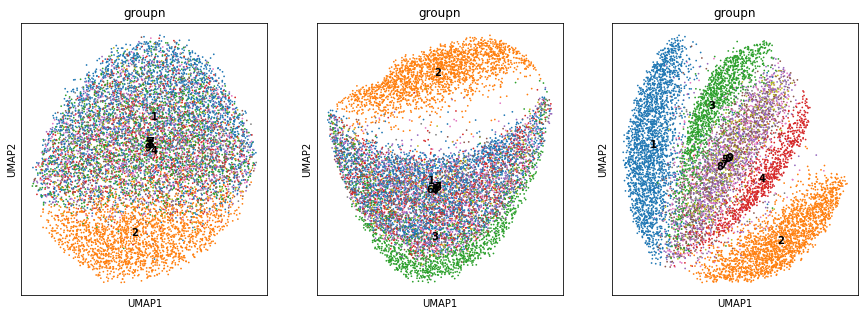

<Figure size 432x288 with 0 Axes>

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Default 
adata_sample = adata_splatter_01.copy()
sc.pp.log1p(adata_sample)
sc.pp.highly_variable_genes(adata_sample, n_top_genes=n_features)
default_HVG = adata_sample.var['highly_variable'].values
sc.pp.pca(adata_sample, use_highly_variable=True)
sc.pp.neighbors(adata_sample, n_neighbors=35)
sc.tl.umap(adata_sample, random_state=seed, min_dist=0.5)
sc.pl.umap(adata_sample, color='groupn', ax=axs[0], show=False, legend_loc='on data')

# Using uncorrected distances
adata_sample = adata_splatter_01.copy()
dist_uncorrected = adata_sample.var['emd_distance_uncorrected'] - adata_sample.var['emd_distance_random']
cutoff = np.sort(dist_uncorrected)[-n_features]
adata_sample.var['highly_variable'] = dist_uncorrected >= cutoff

sc.pp.log1p(adata_sample)
sc.pp.pca(adata_sample)
sc.pp.neighbors(adata_sample, n_neighbors=35)
sc.tl.umap(adata_sample, random_state=seed, min_dist=0.5)
sc.pl.umap(adata_sample, color='groupn', ax=axs[1], show=False, legend_loc='on data')

# Using corrected distances (default)
adata_sample = adata_splatter_01.copy()
sc.pp.log1p(adata_sample)
sc.pp.pca(adata_sample)
sc.pp.neighbors(adata_sample, n_neighbors=35)
sc.tl.umap(adata_sample, random_state=seed, min_dist=0.5)
sc.pl.umap(adata_sample, color='groupn', ax=axs[2], legend_loc='on data')

plt.tight_layout()

We see that either scanpy's HVG and uncorrected features can only separate the secnd group from the rest of the groups (uncorrected triku can start to separate the third group, but only slightly). After correction, the first 4 groups are separated, which is far better than the initial case.

... storing 'Batch' as categorical
... storing 'Group' as categorical
... storing 'groupn' as categorical


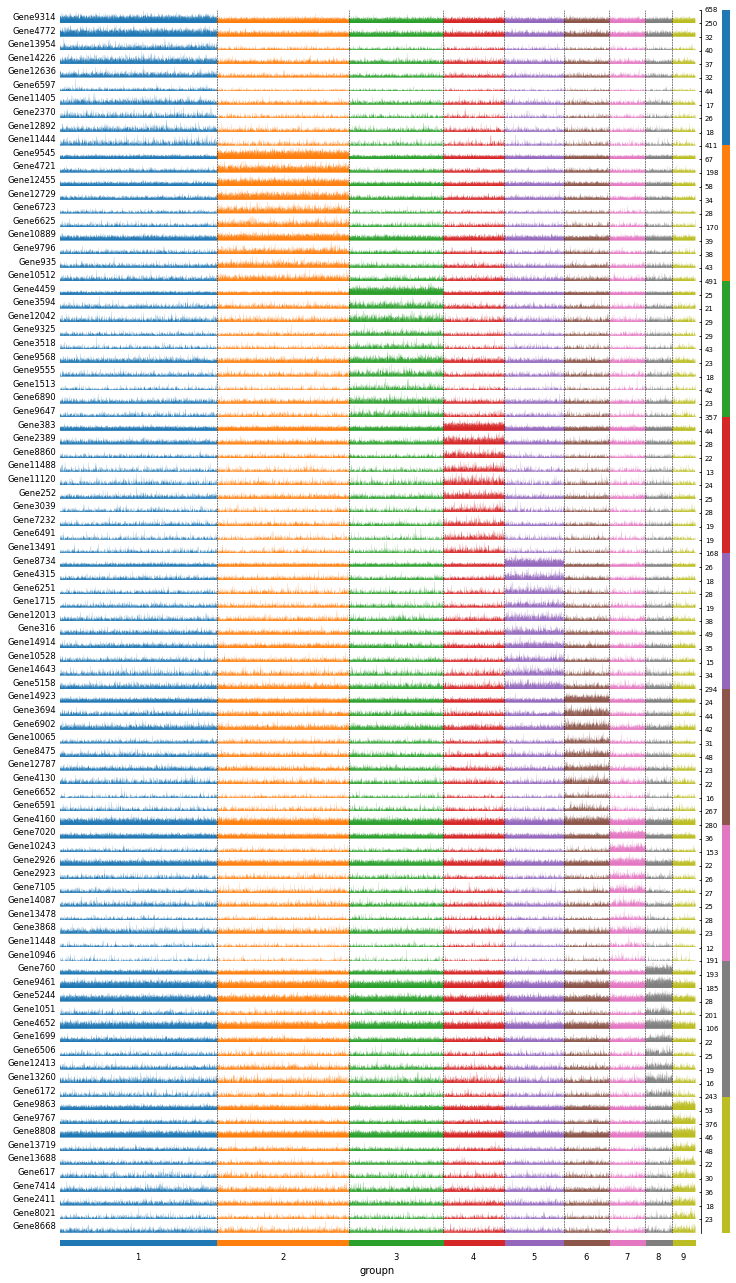

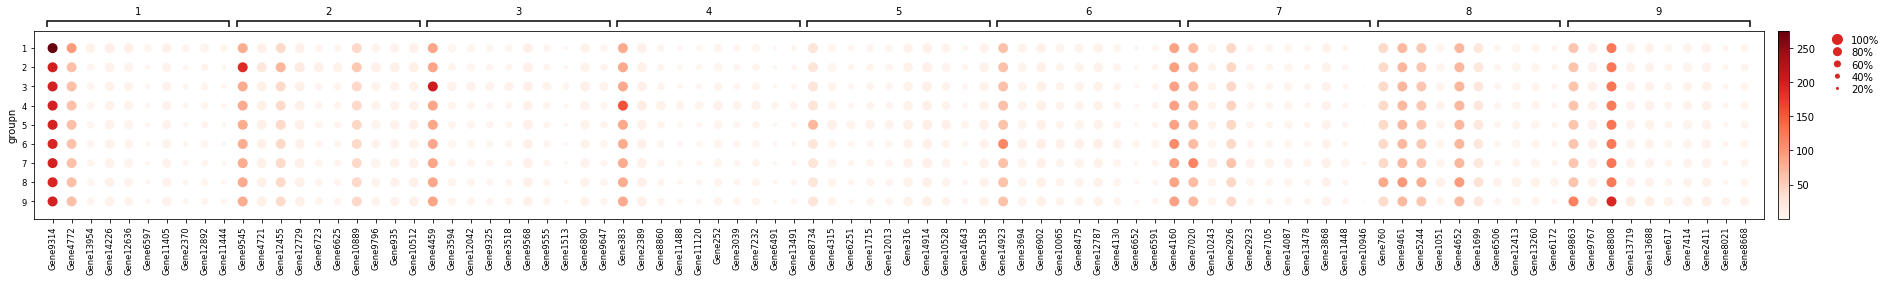

In [18]:
sc.tl.rank_genes_groups(adata_splatter_01, groupby='groupn', method='t-test', n_genes=10)
sc.pl.rank_genes_groups_tracksplot(adata_splatter_01, dendrogram=False, n_genes=10)
sc.pl.rank_genes_groups_dotplot(adata_splatter_01, dendrogram=False, n_genes=10)

In [19]:
DEGs = adata_splatter_01.uns['rank_genes_groups']['names']
DEGs = np.asarray(DEGs.tolist()).flatten()

In [20]:
print('Percentage of DEGs that are corrected features: {}'.format(np.sum(np.array([gene in adata_sample.var_names[highly_variable_corrected] for gene in DEGs]))))
print('Percentage of DEGs that are uncorrected features: {}'.format(np.sum(np.array([gene in adata_sample.var_names[highly_variable_uncorrected] for gene in DEGs]))))
print('Percentage of DEGs that are scanpy features: {}\n'.format(np.sum(np.array([gene in adata_sample.var_names[default_HVG] for gene in DEGs]))))


for gene in DEGs:
    print(gene + ' ' * (9 - len(gene)), gene in adata_sample.var_names[highly_variable_corrected], gene in adata_sample.var_names[highly_variable_uncorrected], gene in adata_sample.var_names[default_HVG])

Percentage of DEGs that are corrected features: 57
Percentage of DEGs that are uncorrected features: 18
Percentage of DEGs that are scanpy features: 21

Gene9314  True True False
Gene9545  True True True
Gene4459  True True True
Gene383   True True True
Gene8734  False False True
Gene14923 True True True
Gene7020  False True True
Gene760   False False True
Gene9863  True True False
Gene4772  True True True
Gene4721  True True True
Gene3594  True False False
Gene2389  True False False
Gene4315  True False False
Gene3694  True False False
Gene10243 False False True
Gene9461  False True False
Gene9767  True False True
Gene13954 True False True
Gene12455 True True True
Gene12042 True False False
Gene8860  True False False
Gene6251  True False False
Gene6902  False False False
Gene2926  False False False
Gene5244  False False False
Gene8808  False True False
Gene14226 True False False
Gene12729 True True True
Gene9325  True False False
Gene11488 True False True
Gene1715  False False False
G

We see that the proportion of genes shared after correction is three times higher, which explains the results above.

In [21]:
is_DEG = [i in DEGs for i in adata_sample.var_names]
highly_variable_corrected = adata_sample.var['highly_variable']
color = []
labels = []
alpha = [0.8 if highly_variable_corrected[i] or is_DEG[i] else 0.4 for i in range(len(highly_variable_uncorrected))]

for i in range(len(highly_variable_uncorrected)):
    if highly_variable_corrected[i] and is_DEG[i]:
        color.append("#000000")
        labels.append('Both')
    elif highly_variable_corrected[i] and not is_DEG[i]:
        color.append("#900020")
        labels.append('Corrected')
    elif not highly_variable_corrected[i] and is_DEG[i]:
        color.append("#007ab7")
        labels.append('DEG')
    else:
        color.append("#bcbcbc")
        labels.append('None')


df_bokeh = pd.DataFrame({
    'm': np.log10(np.asarray(adata_splatter_01.X.todense()).mean(0)),
    'z': (np.asarray(adata_splatter_01.X.todense()) == 0).sum(0) / adata_splatter_01.shape[0],
    'n': adata_splatter_01.var_names.values,
    'd': adata_splatter_01.var["emd_distance_uncorrected"],
    'e': adata_splatter_01.var["emd_distance_uncorrected"] - adata_splatter_01.var["emd_distance_random"],
    'e_correct': adata_splatter_01.var["emd_distance"],
    'color': color, 'label':labels, 'alpha':alpha
    })[:]

In [22]:
p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

p.scatter('m', 'e_correct', source=df_bokeh,
           line_color=None,
         color='color', legend_group='label', alpha='alpha')

p.legend.location = 'top_left'
show(p)

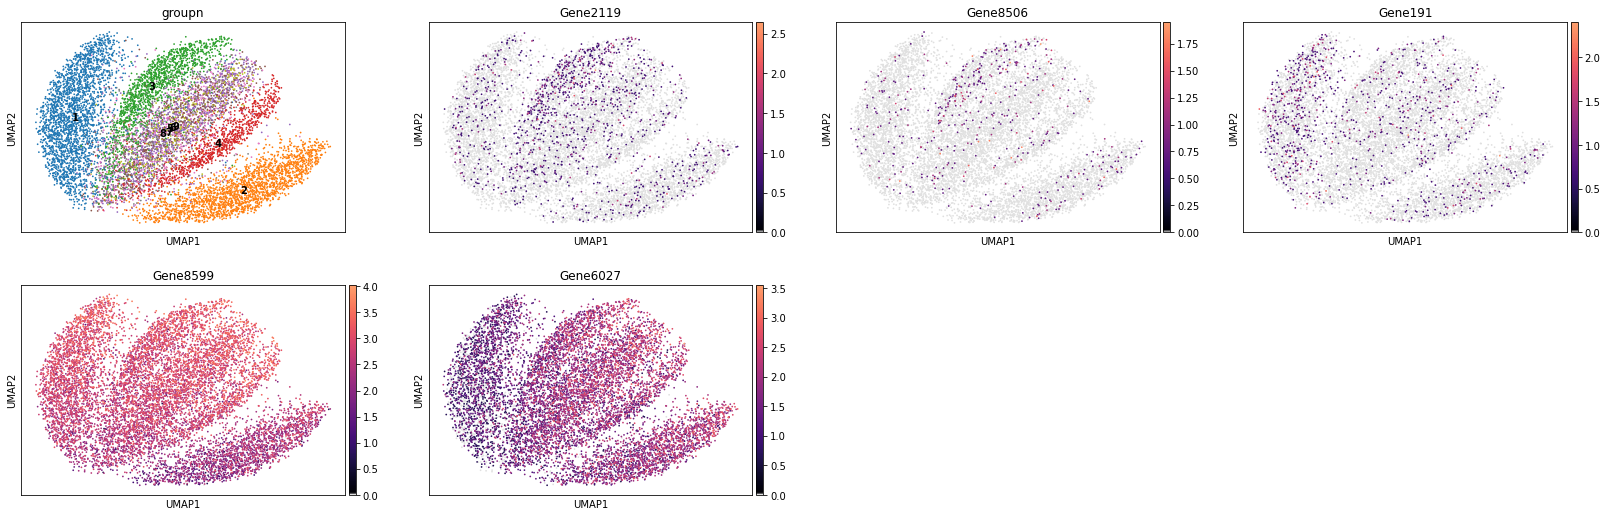

In [23]:
sc.pl.umap(adata_sample, color=['groupn', 'Gene2119', 'Gene8506', 'Gene191', 'Gene8599', 'Gene6027'], 
           legend_loc='on data', cmap=magma)


We even see that some of the genes that were not selected as DEGs have indeed different expression pattern in other groups.

## 10x biological dataset: PBMC 10k

We'll repeat the process with the 10X BPMC 10k dataset. Since in this case we don't have a ground truth to compare to, we will compare patterns of clusters and DEGs to see improvements in cluster detection. The rationale behind this method is to run UMAP using each of sets of features (scanpy's HVG, triku befor and after median correction), run leiden on scanpy's HVG, the map the clustering solution to the rest of the clusters, and vice-versa. We will use the same resolution for all cases, so that the only free variable is the feature selection. We should expect clusters in scanpy's leiden solution to be less informative than in triku's HVG. We compare triku after correction with scanpy, and not with triku before correction because triku before correction and scanpy show similar results.

In [ ]:
# In this dataset we begin to see cluster separation, but is not fully resolved.
adata_PBMC_10k = sc.read_10x_h5(dataset_dir + '10x/pbmc_10k_v3_filtered_feature_bc_matrix.h5') 
sc.pp.filter_genes(adata_PBMC_10k, min_cells=10)
adata_PBMC_10k.var_names_make_unique()

In [ ]:
tk.tl.triku(adata_PBMC_10k, n_windows=100, s=0, random_state=seed, verbose='triku')

In [ ]:
dist_uncorrected = adata_PBMC_10k.var['emd_distance_uncorrected'] - adata_PBMC_10k.var['emd_distance_random']
n_features = np.sum(adata_PBMC_10k.var['highly_variable'].values)
cutoff = np.sort(dist_uncorrected)[-n_features]
highly_variable_uncorrected = dist_uncorrected > cutoff
highly_variable_corrected = adata_PBMC_10k.var['highly_variable']
color = []
labels = []

for i in range(len(highly_variable_uncorrected)):
    if highly_variable_corrected[i] and highly_variable_uncorrected[i]:
        color.append("#000000")
        labels.append('Both')
    elif highly_variable_corrected[i] and not highly_variable_uncorrected[i]:
        color.append("#900020")
        labels.append('Corrected')
    elif not highly_variable_corrected[i] and highly_variable_uncorrected[i]:
        color.append("#007ab7")
        labels.append('Uncorrected')
    else:
        color.append("#bcbcbc")
        labels.append('None')


df_bokeh = pd.DataFrame({
    'm': np.log10(np.asarray(adata_PBMC_10k.X.todense()).mean(0)),
    'z': (np.asarray(adata_PBMC_10k.X.todense()) == 0).sum(0) / adata_PBMC_10k.shape[0],
    'n': adata_PBMC_10k.var_names.values,
    'd': adata_PBMC_10k.var["emd_distance_uncorrected"],
    'e': adata_PBMC_10k.var["emd_distance_uncorrected"] - adata_PBMC_10k.var["emd_distance_random"],
    'e_correct': adata_PBMC_10k.var["emd_distance"],
    'color': color, 'label':labels
    })[:]

In [ ]:
p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

p.scatter('m', 'e_correct', source=df_bokeh,
          alpha=0.7, line_color=None,
         color='color', legend_group='label')

p.legend.location = 'top_right'
show(p)

In [ ]:
p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

p.scatter('m', 'e', source=df_bokeh,
          alpha=0.7, line_color=None,
         color='color', legend_group='label')

p.legend.location = 'top_right'
show(p)

There seems not to be that much of a difference, but we will see later that the selection of certain genes not in blue, but in red, improves the quality of the clustering.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Default 
adata_sample = adata_PBMC_10k.copy()
sc.pp.log1p(adata_sample)
sc.pp.highly_variable_genes(adata_sample, n_top_genes=n_features)
default_HVG = adata_sample.var['highly_variable'].values
sc.pp.pca(adata_sample)
sc.pp.neighbors(adata_sample, n_neighbors=35)
sc.tl.umap(adata_sample, random_state=seed, min_dist=0.5)
sc.tl.leiden(adata_sample, resolution=0.8, random_state=seed)
leiden_res_scanpy = adata_sample.obs['leiden']
sc.pl.umap(adata_sample,  color='leiden', ax=axs[0], show=False, legend_loc='on data', palette=bold_and_vivid)

# Using uncorrected distances
adata_sample = adata_PBMC_10k.copy()
dist_uncorrected = adata_sample.var['emd_distance_uncorrected'] - adata_sample.var['emd_distance_random']
cutoff = np.sort(dist_uncorrected)[-n_features]
adata_sample.var['highly_variable'] = dist_uncorrected >= cutoff

sc.pp.log1p(adata_sample)
sc.pp.pca(adata_sample)
sc.pp.neighbors(adata_sample, n_neighbors=35)
sc.tl.umap(adata_sample, random_state=seed, min_dist=0.5)
adata_sample.obs['leiden'] = leiden_res_scanpy
sc.pl.umap(adata_sample, color='leiden', ax=axs[1], show=False, legend_loc='on data', palette=bold_and_vivid)

# Using corrected distances (default)
adata_sample = adata_PBMC_10k.copy()
sc.pp.log1p(adata_sample)
sc.pp.pca(adata_sample)
sc.pp.neighbors(adata_sample, n_neighbors=35)
sc.tl.umap(adata_sample, random_state=seed, min_dist=0.5)
adata_sample.obs['leiden'] = leiden_res_scanpy
sc.pl.umap(adata_sample, color='leiden', ax=axs[2], legend_loc='on data', palette=bold_and_vivid)

plt.tight_layout()

There are a couple of remarkable differences:
* Clusters  3 and 6 appear completely mixed in triku's UMAPs. 
* Cluster 10 is integrated within cluster 0
* There's a bigger mixing of clusters 0 and 4

We will study mainly the first two cases, which are more interesting.To do that, we will get the DEGs and calculate the logfold change in clusters, as well as the score (related to p-value). Then, we will compare them to the ones obtained with the DEGs using the leiden solution with triku features.

In [ ]:
adata_PBMC_10k.uns['leiden_colors'] = adata_sample.uns['leiden_colors']

In [ ]:
adata_PBMC_10k.obs['leiden'] = leiden_res_scanpy
sc.tl.rank_genes_groups(adata_PBMC_10k, groupby='leiden', method='t-test')
sc.pl.rank_genes_groups_tracksplot(adata_PBMC_10k, dendrogram=False, n_genes=15, palette=bold_and_vivid)

In [ ]:
df_scores_scanpy = pd.DataFrame(adata_PBMC_10k.uns['rank_genes_groups']['scores'])
df_DEGs_scanpy = pd.DataFrame(adata_PBMC_10k.uns['rank_genes_groups']['names'])
df_logfold_scanpy = pd.DataFrame(adata_PBMC_10k.uns['rank_genes_groups']['logfoldchanges'])

Repeat the UMAPs and leiden clustering.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Using corrected distances (default)
adata_sample = adata_PBMC_10k.copy()
sc.pp.log1p(adata_sample)
sc.pp.pca(adata_sample)
sc.pp.neighbors(adata_sample, n_neighbors=35)
sc.tl.umap(adata_sample, random_state=seed, min_dist=0.5)
sc.tl.leiden(adata_sample, resolution=0.8, random_state=seed)
leiden_res_corrected = [i + '*' for i in adata_sample.obs['leiden']]
adata_sample.obs['leiden'] = leiden_res_corrected
sc.pl.umap(adata_sample, color='leiden', ax=axs[2], show=False, legend_loc='on data', palette=bold_and_vivid)

# Default 
adata_sample = adata_PBMC_10k.copy()
sc.pp.log1p(adata_sample)
sc.pp.highly_variable_genes(adata_sample, n_top_genes=n_features)
default_HVG = adata_sample.var['highly_variable'].values
sc.pp.pca(adata_sample)
sc.pp.neighbors(adata_sample, n_neighbors=35)
sc.tl.umap(adata_sample, random_state=seed, min_dist=0.5)
adata_sample.obs['leiden'] = leiden_res_corrected
sc.pl.umap(adata_sample,  color='leiden', ax=axs[0], show=False, legend_loc='on data', palette=bold_and_vivid)

# Using uncorrected distances
adata_sample = adata_PBMC_10k.copy()
dist_uncorrected = adata_sample.var['emd_distance_uncorrected'] - adata_sample.var['emd_distance_random']
cutoff = np.sort(dist_uncorrected)[-n_features]
adata_sample.var['highly_variable'] = dist_uncorrected >= cutoff

sc.pp.log1p(adata_sample)
sc.pp.pca(adata_sample)
sc.pp.neighbors(adata_sample, n_neighbors=35)
sc.tl.umap(adata_sample, random_state=seed, min_dist=0.5)
adata_sample.obs['leiden'] = leiden_res_corrected
sc.pl.umap(adata_sample, color='leiden', ax=axs[1], legend_loc='on data', palette=bold_and_vivid)



plt.tight_layout()

Some peculiarities arise:
* 3* and 9* clusters now are separated. The UMAP in scanpy's featues seems more resolved, but 3 and 6 from then are not exactly 3 and 6 from now, which is strange. Maybe it was a bad clustering solution in previous UMAPs.
* Cluster 17* areises as a separated cluster iun triku's features.
* Clusters 12* and 16* seem completely integrated in cluster 2 in leiden from scanpy feature selection.
* Relationships between clusters 1\*, 2\*, 5\*, 6\*, 7\*, 8\*, and 11\* become more apparent. For example, cluster 11\* expression is clearly an intermediate between 5\* and 8\*, whereas this relationship is less apparent when looking at the corresponding clusters 5, 7, 8.  Also, clusters 1\*, 2\*, 6\* and 7\* seem to be more separated than 0 and 4.

In [ ]:
adata_PBMC_10k.uns['leiden_colors'] = adata_sample.uns['leiden_colors']

In [ ]:
adata_PBMC_10k.obs['leiden'] = leiden_res_corrected
sc.tl.rank_genes_groups(adata_PBMC_10k, groupby='leiden', method='t-test', dendrogram=False)
sc.pl.rank_genes_groups_tracksplot(adata_PBMC_10k, dendrogram=False, n_genes=15)

In [ ]:
df_scores_triku = pd.DataFrame(adata_PBMC_10k.uns['rank_genes_groups']['scores'])
df_DEGs_triku = pd.DataFrame(adata_PBMC_10k.uns['rank_genes_groups']['names'])
df_logfold_triku = pd.DataFrame(adata_PBMC_10k.uns['rank_genes_groups']['logfoldchanges'])

In [ ]:
def compare_triku_scanpy(list_cols_triku, list_cols_scanpy, N):
    list_genes = list(set(df_DEGs_triku[list_cols_triku].loc[:N].values.ravel().tolist() + 
                     df_DEGs_scanpy[list_cols_scanpy].loc[:N].values.ravel().tolist()))
    list_logfold_max_triku, list_logfold_max_scanpy = [], []
    list_score_max_triku, list_score_max_scanpy = [], []

    for gene in list_genes:
        df_numeric_triku = df_logfold_triku[df_DEGs_triku[list_cols_triku].loc[:] == gene].fillna(0)
        df_numeric_scanpy = df_logfold_scanpy[df_DEGs_scanpy[list_cols_scanpy].loc[:] == gene].fillna(0)

        list_logfold_max_triku.append(df_numeric_triku.values.max())
        list_logfold_max_scanpy.append(df_numeric_scanpy.values.max())

        df_numeric_triku = df_scores_triku[df_DEGs_triku[list_cols_triku].loc[:] == gene].fillna(0)
        df_numeric_scanpy = df_scores_scanpy[df_DEGs_scanpy[list_cols_scanpy].loc[:] == gene].fillna(0)

        list_score_max_triku.append(df_numeric_triku.values.max())
        list_score_max_scanpy.append(df_numeric_scanpy.values.max())
    
    
    df_max_vals_logs = pd.DataFrame({'gene': list_genes, 'max_triku': list_logfold_max_triku, 
                            'max_scanpy': list_logfold_max_scanpy})
    df_max_vals_logs['sum'] = df_max_vals_logs['max_triku'] + df_max_vals_logs['max_scanpy']
    df_max_vals_logs = df_max_vals_logs.sort_values(by='sum', ascending=False)

    df_max_vals_score = pd.DataFrame({'gene': list_genes, 'max_triku': list_score_max_triku, 
                                'max_scanpy': list_score_max_scanpy})
    df_max_vals_score['sum'] = df_max_vals_score['max_triku'] + df_max_vals_score['max_scanpy']
    df_max_vals_score = df_max_vals_score.sort_values(by='sum', ascending=False)
    
    p = figure(x_range=df_max_vals_logs['gene'].values, plot_width=900, plot_height=300,
               y_axis_label='Logfold change')

    p.vbar(x = dodge('gene', -0.19, range=p.x_range), top = 'max_triku', width=0.175, source=df_max_vals_logs, 
           color="#900020", legend_label='triku')
    p.vbar(x = dodge('gene', 0.19, range=p.x_range), top = 'max_scanpy', width=0.175, source=df_max_vals_logs,
          legend_label='scanpy')
    p.xaxis.major_label_orientation = 0.85
    show(p)
    
    
    p = figure(x_range=df_max_vals_score['gene'].values, plot_width=900, plot_height=300,
               y_axis_label='Rank gene score')

    p.vbar(x = dodge('gene', -0.19, range=p.x_range), top = 'max_triku', width=0.175, source=df_max_vals_score, color="#900020")
    p.vbar(x = dodge('gene', 0.19, range=p.x_range), top = 'max_scanpy', width=0.175, source=df_max_vals_score)
    p.xaxis.major_label_orientation = 0.85
    show(p)
    

### Comparing scanpy's 3 and 7 clusters with triku's 4* and 8* clusters.

In [ ]:
# Red is triku, blue is scanpy
compare_triku_scanpy(['3*', '9*'], ['3', '6'], 15)

We see that scanpy's HVG detection is generally outperformed by triku's, either by logfold changes or by rank gene scores. 

### Comparing scanpy's 4 cluster with triku's 2* cluster.

In [ ]:
# Red is triku, blue is scanpy
compare_triku_scanpy(['2*'], ['4'], 15)

Although logfold changes are higher in scanpy, all scores are better in triku. If we examine closely the trackplots from triku and scanpy, we see that the first DEGs in cluster 4 do not show almost any expression, neither even jointly with other clusters. On the other hand, DEGs in cluster 2\*, although  coexpressed with clusters 1\*, 5\*, 7\* and 11\*, there is a marked expression.

### Triku tells cluster 17* apart from clusters 3* and 9*, scanpy does not

In [ ]:
# Using corrected distances (default)
adata_sample_triku = adata_PBMC_10k.copy()
sc.pp.log1p(adata_sample_triku)
sc.pp.pca(adata_sample_triku)
sc.pp.neighbors(adata_sample_triku, n_neighbors=35)
sc.tl.umap(adata_sample_triku, random_state=seed, min_dist=0.5)

In [ ]:
# Default 
adata_sample_scanpy = adata_PBMC_10k.copy()
sc.pp.log1p(adata_sample_scanpy)
sc.pp.highly_variable_genes(adata_sample_scanpy, n_top_genes=n_features)
sc.pp.pca(adata_sample_scanpy)
sc.pp.neighbors(adata_sample_scanpy, n_neighbors=35)
sc.tl.umap(adata_sample_scanpy, random_state=seed, min_dist=0.5)

In [ ]:
sc.pl.umap(adata_sample_triku, color=df_DEGs_triku['17*'].loc[:15].values,  legend_loc='on data', cmap=magma, ncols=2)

In [ ]:
sc.pl.umap(adata_sample_scanpy, color=df_DEGs_triku['17*'].loc[:15].values,  legend_loc='on data', cmap=magma, ncols=2)

We see that cluster 17\* has a mixed expression from clusters 3\* and 9\*, and cluster 15\*. Scanpy's feature selection would not have directly found that cluster.

### Cluster 10 is irrelevant for analysis
If we look at DEGs from cluster 10, all genes are RPS, which are irrelevant for the analysis, and CD8B, which is also expressed in cluster . Cluster 10 lacks expression of NKG7, HCST and CST7. Cluster 8 expression signature is really similar to one of clusters 5 and 6 and, in fact, 8 cluster merges into clusters 5\* and 11\*, which do have more independent signatures. 

In [ ]:
list(df_DEGs_scanpy['10'][:20].values)

# Conclusions / wrapup
Applying the median correction seems not to be a mistake either for artificial or biological datasets. If it does not provide an improvement, it at least does not reduce the quality of the clustering or dimensionality reduction, which is good. We will do more thorough analyses in the following noteboooks to compare triku to other feature selection methods.